# **- scikit-learn이란**


 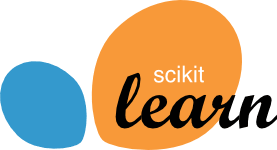

​ scikit-learn이란 python을 대표하는 머신러닝 라이브러리이다. '사이킷런'이라고 부르기도 한다. 
scikit-learn은 오픈 소스로 공개되어 있으며, 개인, 비즈니스 관계없이 누구나 무료로 사용가능하다. scikit-learn은 현재도 활용하여 개발이 이루어지고 있으며, 인터넷 상에서 정보를 찾기에도 쉽다. 많은 머신러닝 알고리즘이 구현되어 있는데, 어떤 알고리즘도 같은 방식으로 이용이 가능하다. 또, 샘플 데이터 셋(토이 데이터 셋)이 부속되어 있으므로, 설치하여 바로 기계 학습을 시험해볼 수 있다. 그러므로 초심자가 기계학습을 배우기 시작할 때 적합한 라이브러리라고 말한다.

# **- scikit-learn의 주요 기능**

​
 다음은 scikit-learn의 주요한 기능, 특히 기계학습 모델에 대해 설명한다. 아래의 이미지는 scikit-learn의 알고리즘 치트 시트로 불린다. 

 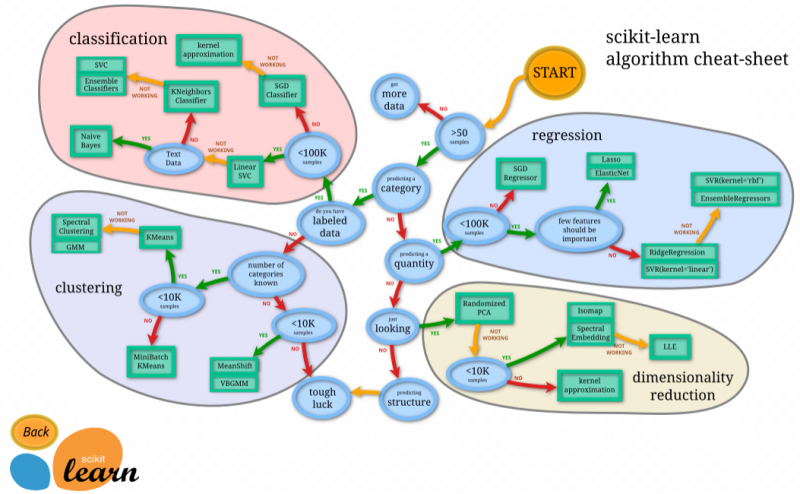
 
 scikit-learn을 이용하여 기계학습을 실행할 때, 자신이 하고 싶은 분석(분류/회귀/클러스터링 등)에 대해서 적당한 모델을 선택하는 것에 대해 도움이 된다. 그리고 scikit-learn으로 간단히 모델을 바꿔 기계학습을 하는 것도 가능하다. 


# **- CSIC 2010 데이터셋을 활용한 웹공격탐지**

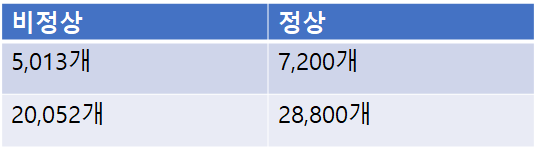

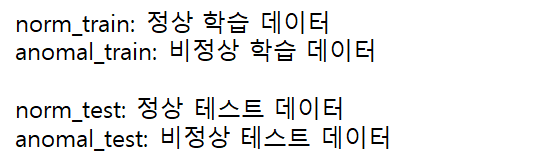

위와 같은 구조를 가진 데이터셋을 사이킷런 모델중 분류,회귀 모델로 학습하여 접근이 정상 로그인지 비정상 로그인지 확인하는 분류기 성능을 테스트 해보는 것을 목적으로 한다.

# **- 테스트 목록**

**1. 분류 모델**

    from sklearn.svm import SVC

    from sklearn.tree import DecisionTreeClassifier

    from sklearn.ensemble import RandomForestClassifier

    from sklearn.ensemble import AdaBoostClassifier

    from sklearn.neighbors import KNeighborsClassifier

    from sklearn.neural_network import MLPClassifier
    

**2. 회귀 모델**

    from sklearn.linear_model import LogisticRegression

# **- 코드 및 실행결과와 성능 테스트 결과**

In [ ]:
# mount
from google.colab import drive
drive.mount('/content/drive')
ROOT = '/content/drive/My Drive/Colab Notebooks/infosec/proj1/'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import io
import urllib.parse
import numpy as np

In [ ]:
anomaly_train_raw = "anomal_train.txt"
anomaly_test_raw = "anomal_test.txt"
normal_train_raw = "norm_train.txt"
normal_test_raw = "norm_test.txt"

In [ ]:
def parse(file_in, file_out):
    f = open(ROOT + file_in, 'r', encoding="utf8")
    lines = list(map(lambda line: line.strip(), f.readlines()))
    res = []
    for i in range(len(lines)):
        line = lines[i]
        words = line.split(' ')
        url_req = None
        is_req = False
        if line.startswith("GET"):
            is_req = True
            url_req = words[0] + words[1]
        elif line.startswith("POST") or line.startswith("PUT"):
            is_req = True
            url_req = words[0] + words[1]
            idx = 1
            while not lines[i + idx].startswith("Content-Length"):
                idx += 1
            url_req += '?' + lines[i + idx + 2]
        if is_req:
            res.append(url_req)
    f.close()

    out = io.open(file_out, 'w', encoding="utf-8")
    for e in res:
        out.writelines(urllib.parse.unquote(e).replace('\n','').lower() + '\n')
    print("Parsing complete.", len(res), "requests earned from", file_in)

def load_parsed(file):
    with open(file, 'r', encoding="utf8") as f:
        data = f.readlines()
    ret = []
    for i in data:
        i = i.strip()
        if i != '':
            ret.append(i)
    return ret

# 0: normal, 1: anomaly
def make_data_set(parsed, label):
    return {
        "data": parsed,
        "target": np.array([label] * len(parsed), dtype=np.uint8),
        "target_names": np.array(["normal", "anomaly"])
    }

def combine_data_set(a: dict, b: dict):
    try:
        if not np.array_equal(a["target_names"], b["target_names"]):
            print("Invalid combining!")
            return False
    except:
        print("Invalid combining!!!")
        return False
    return {
        "data": a["data"] + b["data"],
        "target": np.append(a["target"], b["target"]),
        "target_names": a["target_names"].copy()
    }

In [ ]:
parse(normal_train_raw, "normal_train.txt")
parse(normal_test_raw, "normal_test.txt")
parse(anomaly_train_raw, "anomaly_train.txt")
parse(anomaly_test_raw, "anomaly_test.txt")

Parsing complete. 28800 requests earned from norm_train.txt
Parsing complete. 7200 requests earned from norm_test.txt
Parsing complete. 20052 requests earned from anomal_train.txt
Parsing complete. 5013 requests earned from anomal_test.txt


In [ ]:
trainset = make_data_set(load_parsed("normal_train.txt"), 0)
trainset = combine_data_set(trainset, make_data_set(load_parsed("anomaly_train.txt"), 1))
testset = make_data_set(load_parsed("normal_test.txt"), 0)
testset = combine_data_set(testset, make_data_set(load_parsed("anomaly_test.txt"), 1))

vectorizer = TfidfVectorizer(
        min_df=0,
        analyzer="char",
        sublinear_tf=True,
        ngram_range=(3, 3)
)

X = trainset["data"]
y = trainset["target"]
X_test = testset["data"]
y_test = testset["target"]

vectorizer.fit(X)
X = vectorizer.transform(X)
X_test = vectorizer.transform(X_test)

print(X.shape)
print(X_test.shape)

(48852, 28509)
(12213, 28509)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=31,
    stratify=y
)

In [ ]:
# Logistic Regression
lr = LogisticRegression(
    solver='liblinear',
    multi_class='auto',
    C=90,
    random_state=1
)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
score = accuracy_score(y_pred_lr, y_test)
f1 = f1_score(y_pred_lr, y_test)
print("Logistic Regression 모델의 정확도:", score)
print("Logistic Regression 모델의 F1 score:", f1)

Logistic Regression 모델의 정확도: 0.987554245476132
Logistic Regression 모델의 F1 score: 0.9848665870171247


**-> 속도가 매우 빠르다는 장점을 가지고 있다.**

**-> F1 score가 약 0.98로 높은 편이다.**

In [ ]:
# Decision Tree
dtree = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=150,
    random_state=29
)
dtree.fit(X_train, y_train)

y_pred_dt = dtree.predict(X_test)
score = accuracy_score(y_pred_dt, y_test)
f1 = f1_score(y_pred_dt, y_test)
print("Decision Tree 모델의 정확도 : ", score)
print("Decision Tree 모델의 F1 score:", f1)

Decision Tree 모델의 정확도 :  0.9749447310243183
Decision Tree 모델의 F1 score: 0.9693999999999999


In [ ]:
# Ada Boost
base_model = DecisionTreeClassifier(
    max_depth = 1,
    max_features=0.3,
    class_weight='balanced',
    random_state=1
)
ada_model = AdaBoostClassifier(
    base_estimator = base_model,
    n_estimators = 1000,
    learning_rate=1.,
    random_state=1
)

ada_model.fit(X_train, y_train)

y_pred_ada = ada_model.predict(X_test)
score = accuracy_score(y_pred_ada, y_test)
f1 = f1_score(y_pred_ada, y_test)
print("ADA-BOOST의 정확도:", score)
print("ADA-BOOST의 F1 score:", f1)

ADA-BOOST의 정확도: 0.9816588880700893
ADA-BOOST의 F1 score: 0.9776580889686814


**-> 속도가 매우 느리다.**




In [ ]:
# Random Forest
rf = RandomForestClassifier(
    criterion="entropy",
    n_estimators=180,
    random_state=2,
    n_jobs=4
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
score = accuracy_score(y_pred_rf, y_test)
f1 = f1_score(y_pred_rf, y_test)
print("Random Forest 모델의 정확도:", score)
print("Random Forest 모델의 F1 score:", f1)

Random Forest 모델의 정확도: 0.9705232129697863
Random Forest 모델의 F1 score: 0.9639495293410776


In [ ]:
# SVM
svm = LinearSVC(random_state=1, tol=1e-5, C=1)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
score = accuracy_score(y_pred_svm, y_test)
f1 = f1_score(y_pred_svm, y_test)
print("SVM 모델의 정확도:", score)
print("SVM Forest 모델의 F1 score:", f1)

SVM 모델의 정확도: 0.9872267256202407
SVM Forest 모델의 F1 score: 0.9844435580374951


In [ ]:
# KNeighbors
knn = KNeighborsClassifier(
    n_neighbors=2,
    p=2,
    metric="minkowski"
)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
score = accuracy_score(y_pred_knn, y_test)
f1 = f1_score(y_pred_knn, y_test)
print("KNN 모델의 정확도:", score)
print("KNN 모델의 F1 score:", f1)

KNN 모델의 정확도: 0.9583230983378367
KNN 모델의 F1 score: 0.9474227869021795


**-> KNN 모델은 가장 낮은 성능을 보여주고 있다.**

In [ ]:
# MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(20, 5),
    activation="relu",
    solver="adam",
    batch_size=192,
    learning_rate_init=0.01,
    max_iter=1,
    warm_start=True,
    random_state=7
)

for i in range(1, 101):
    mlp.fit(X_train, y_train)
    
y_pred_mlp = mlp.predict(X_test)
score = accuracy_score(y_pred_mlp, y_test)
f1 = f1_score(y_pred_mlp, y_test)
print("MLP 모델의 정확도:", score)
print("MLP 모델의 F1 score:", f1)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP 모델의 정확도: 0.983951527061328
MLP 모델의 F1 score: 0.9805246422893483


**-> MLP는 속도가 느린 편이다.**

**-> F1 score가 0.98로 높은편이다.**